In [1]:
import numpy as np
import pickle
import os

# Function to unpickle CIFAR-10 files
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Define the path where your CIFAR-10 files are stored
data_path = '/kaggle/input/cifar10/cifar-10-batches-py'  # Adjust if necessary

# Load all training batches
def load_cifar10(data_path):
    train_data = []
    train_labels = []
    
    # Load all batch files
    for i in range(1, 6):
        batch_file = os.path.join(data_path, f'data_batch_{i}')
        batch = unpickle(batch_file)
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])

    # Combine all batches
    train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype("float32")
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(os.path.join(data_path, 'test_batch'))
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).astype("float32")
    test_labels = np.array(test_batch[b'labels'])

    # Load label names
    meta = unpickle(os.path.join(data_path, 'batches.meta'))
    label_names = meta[b'label_names']
    label_names = [label.decode('utf-8') for label in label_names]

    return train_data, train_labels, test_data, test_labels, label_names

# Load the CIFAR-10 data
train_data, train_labels, test_data, test_labels, label_names = load_cifar10(data_path)

# Verify the data
print(f"Training Data Shape: {train_data.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Test Data Shape: {test_data.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Label Names: {label_names}")


Training Data Shape: (50000, 3, 32, 32)
Training Labels Shape: (50000,)
Test Data Shape: (10000, 3, 32, 32)
Test Labels Shape: (10000,)
Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Normalize the data and convert to tensors
from torchvision.transforms import ToPILImage

# Define data augmentation for training
transform_train = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10 mean and std
])

# Define transformations for testing
transform_test = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


# Custom PyTorch Dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].transpose(1, 2, 0)  # Convert to HWC format for transformations
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
import torch
import torch.nn as nn

class LeakyCNN(nn.Module):
    def __init__(self):
        super(LeakyCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.leaky_relu1 = nn.LeakyReLU(0.01)  # Leaky ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.01)  # Leaky ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(0.01)  # Leaky ReLU
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Flatten size: 4*4 from pooling
        self.leaky_relu_fc1 = nn.LeakyReLU(0.01)  # Leaky ReLU
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # Output layer for CIFAR-10 (10 classes)

    def forward(self, x):
        x = self.pool1(self.leaky_relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.leaky_relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.leaky_relu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.drop1(self.leaky_relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x


In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss function, optimizer
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10: 100%|██████████| 782/782 [00:16<00:00, 46.84batch/s, loss=1.83] 


Epoch 1/10, Loss: 1.8285


Epoch 2/10: 100%|██████████| 782/782 [00:16<00:00, 46.93batch/s, loss=1.37] 


Epoch 2/10, Loss: 1.3696


Epoch 3/10: 100%|██████████| 782/782 [00:16<00:00, 47.36batch/s, loss=1.19] 


Epoch 3/10, Loss: 1.1934


Epoch 4/10: 100%|██████████| 782/782 [00:16<00:00, 46.97batch/s, loss=1.08] 


Epoch 4/10, Loss: 1.0805


Epoch 5/10: 100%|██████████| 782/782 [00:16<00:00, 47.80batch/s, loss=0.994]


Epoch 5/10, Loss: 0.9943


Epoch 6/10: 100%|██████████| 782/782 [00:16<00:00, 46.53batch/s, loss=0.927]


Epoch 6/10, Loss: 0.9275


Epoch 7/10: 100%|██████████| 782/782 [00:16<00:00, 47.30batch/s, loss=0.875]


Epoch 7/10, Loss: 0.8749


Epoch 8/10: 100%|██████████| 782/782 [00:16<00:00, 46.33batch/s, loss=0.849]


Epoch 8/10, Loss: 0.8487


Epoch 9/10: 100%|██████████| 782/782 [00:16<00:00, 46.70batch/s, loss=0.808] 


Epoch 9/10, Loss: 0.8079


Epoch 10/10: 100%|██████████| 782/782 [00:16<00:00, 46.96batch/s, loss=0.789]


Epoch 10/10, Loss: 0.7886


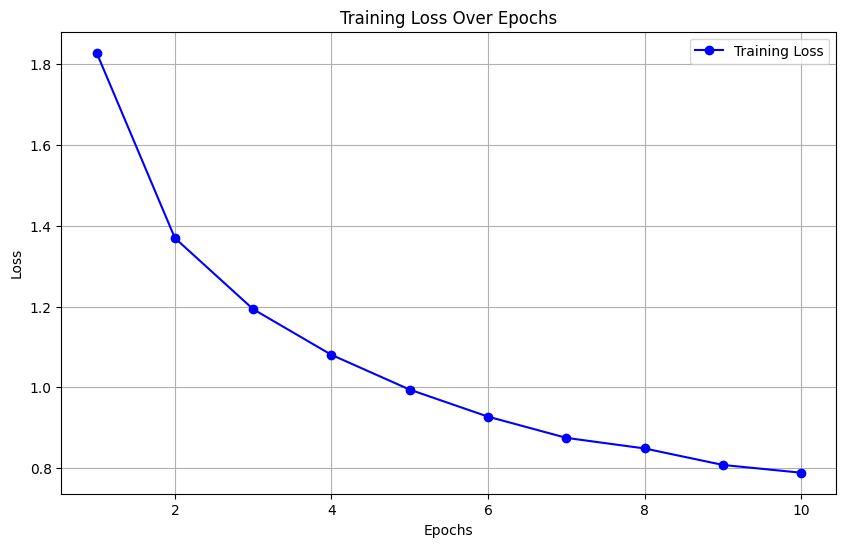

In [19]:
train_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the running loss
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / len(pbar))

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='blue', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [20]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the model on the provided dataset.
    
    Args:
    - model: The trained PyTorch model.
    - dataloader: DataLoader for the evaluation dataset.
    - criterion: Loss function to calculate the loss.
    - device: Device (CPU or GPU) to run the evaluation.

    Returns:
    - Average loss and accuracy over the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed during evaluation
        for inputs, labels in dataloader:
            # Move data to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update total loss
            total_loss += loss.item()
            
            # Calculate predictions and accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

# Example usage
# Assuming you have a trained model `model`, validation dataloader `val_loader`,
# a loss criterion (e.g., nn.CrossEntropyLoss), and device configuration.
val_loss, val_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.6795, Validation Accuracy: 77.44%
